# AI 201 Programming Assignment 3
## Multi-Layer Perceptron with Backpropagation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
import sys
!{sys.executable} -m pip install --quiet numpy matplotlib imblearn tqdm

In [2]:
import numpy as np
import csv
import time
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm

In [3]:
# Dataset paths
path_to_train_set_features = "data.csv"
path_to_train_set_labels = "data_labels.csv"
path_to_test_set_features = "test_set.csv"

# Training and validation set filenames
filename_train_set_features = "training_set.csv"
filename_train_set_labels = "training_labels.csv"
filename_val_set_features = "validation_set.csv"
filename_val_set_labels = "validation_labels.csv"

# Filename for saving the trained weights
filename_network_weights = "trained_weights.csv"

# Filenames for predictions of Network A and Network B
filename_network_a_pred = "predictions_for_test_tanh.csv"
filename_network_b_pred = "predictions_for_test_leakyrelu.csv"

# MLP training parameters and randomization seed
EPOCHS = 500
DEFAULT_BATCH_SIZE = 8
np.random.seed(0)

## Functions for Reading and Writing CSV Files

In [4]:
# Functions for reading and writing CSV files
def read_csv(path):
    data = []

    with open(path, mode="r") as file:
        csv_reader = csv.reader(file)  
        for row in csv_reader:
            data.append(row)
    return np.array(data, dtype=float)

def write_csv(path, data, mode="w"):
    # Save features to a CSV file
    with open(path, mode=mode, newline="") as file:
        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)

X_imbalanced = read_csv(path_to_train_set_features)
Y_imbalanced = read_csv(path_to_train_set_labels)
X_test = read_csv(path_to_test_set_features)

In [5]:
# Function for one-hot encoding labels
def one_hot_encoding(x, length):
    encoding = np.zeros(length)
    encoding[int(x)-1] = 1
    return encoding

Y_one_hot_encoded = Y_imbalanced.tolist().copy()
for i in range(len(Y_one_hot_encoded)):
    Y_one_hot_encoded[i] = one_hot_encoding(Y_one_hot_encoded[i][0], 8)
Y_one_hot_encoded = np.array(Y_one_hot_encoded)

## Balancing the Dataset via SMOTE

In [6]:
# Balance out the existing dataset via SMOTE
smote = SMOTE()
X_balanced, Y_balanced = smote.fit_resample(X_imbalanced, Y_one_hot_encoded)

## Splitting the Dataset into Training and Validation Sets

In [7]:
def train_val_split(X, Y, val_size, random_state=None):    
    # Pair each document with its label
    paired = list(zip(X, Y))
    
    # Shuffle the paired documents and labels
    np.random.shuffle(paired)
    
    # Calculate the number of samples in the validation set
    if isinstance(val_size, float):
        val_size = int(len(X)-800)
    
    # Split the paired list into training and validation sets
    train_pairs = paired[:-val_size]
    val_pairs = paired[-val_size:]
    
    # Unzip the pairs back into separate lists
    train_features, train_labels = zip(*train_pairs)
    val_features, val_labels = zip(*val_pairs)
    
    return np.array(train_features), np.array(val_features), np.array(train_labels), np.array(val_labels)

# Retrieve the training, validation, and test sets from the balanced dataset
X_train, X_val, Y_train, Y_val = train_val_split(X_balanced, Y_balanced, val_size=800, random_state=0)
X_eval, Y_eval = X_imbalanced, Y_imbalanced

print(X_balanced.shape)
print(Y_balanced.shape)
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(13000, 354)
(13000, 8)
(12200, 354)
(800, 354)
(12200, 8)
(800, 8)


In [8]:
# Save the training and validation sets as CSV files
write_csv(filename_train_set_features, X_train)
write_csv(filename_train_set_labels, Y_train)
write_csv(filename_val_set_features, X_val)
write_csv(filename_val_set_labels, Y_val)

## Metrics Calculation Functions

In [9]:
# Functions for calculating the model metrics
def probabilities_to_class_labels(Y_probs):
    return np.argmax(Y_probs, axis=1) + 1

def count_misclassifications(Y_true, Y_pred):
    misclassifications = 0
    for i in range(Y_true.shape[0]):
        if Y_true[i] != Y_pred[i]:
            misclassifications += 1
    
    return misclassifications

def confusion_matrix(Y_true, Y_pred):
    K = len(np.unique(Y_true))  # Number of classes
    result = np.zeros((K, K))

    for i in range(len(Y_true)):
        # Directly use Y_true[i] and Y_pred[i] as indices
        result[Y_true[i] - 1, Y_pred[i] - 1] += 1

    return result

def plot_confusion_matrix(Y_true, Y_pred, labels=None):
    cm = confusion_matrix(Y_true, Y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks and label them with the respective list entries
    if labels is None:
        labels = np.unique(np.concatenate((Y_true, Y_pred)))
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if cm.dtype == 'float' else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.show()

def calculate_model_metrics(Y_true, Y_pred):
    # Print the confusion matrix
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    
    # Compute the accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    
    # Compute the precision, recall, and f1-score per class
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Compute the macro averages for precision, recall, and f1-score
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_scores)
    
    # Compute the Matthews Correlation Coefficient (MCC)
    mcc_numerator = np.sum(np.diag(conf_matrix) * np.sum(conf_matrix) - np.sum(conf_matrix, axis=0) * np.sum(conf_matrix, axis=1))
    mcc_denominator = np.sqrt(np.sum(conf_matrix) * np.sum(conf_matrix, axis=0) * np.sum(conf_matrix, axis=1) * np.sum(conf_matrix))
    mcc = mcc_numerator / mcc_denominator
    
    return accuracy, macro_precision, macro_recall, macro_f1_score, mcc

## Activation Functions Implementations

In [10]:
class LogisticFunction:
    
    def __init__(self, a=2.0):
        self.a = a
        
    # Numerically stable version for computing the logistic function
    # Uses two versions of the expression depending on the element-wise
    # value of x
    def forward(self, x):
        # Mask for determining which expression to use for logistic function
        pos_mask = (x >= 0)
        z = np.where(pos_mask, np.exp(-self.a * x), np.exp(self.a * x))
        sigma = np.where(pos_mask, 1 / (1 + z), z / (1 + z))
        return sigma
    
    def backward(self, x):
        sigma = self.forward(x)
        return self.a * sigma * (1 - sigma)
    
class Tanh:
    
    def __init__(self, a=1.716, b=2/3):
        self.a = a
        self.b = b
        
    def forward(self, x):
        return self.a * np.tanh(x * self.b)

    def backward(self, x):
        return self.a*self.b * (1/np.cosh(self.b*x))**2
    
class LeakyReLU:
    
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    
    def forward(self, x):
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, x):
        return np.where(x > 0, 1, self.alpha)

## Multi-Layer Perceptron Implementation

In [11]:
class MultiLayerPerceptron:
    
    def __init__(self, input_size, hidden_sizes, output_size, 
                activation_functions=[Tanh(), Tanh(), LogisticFunction()], 
                learning_rate=0.01,
                momentum=0.9, 
                seed=0,
                verbosity=1):
        
        # Network architecture parameters
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_functions = activation_functions

        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.depth = len(self.layer_sizes)
        # print(f"layer_sizes = {self.layer_sizes}")

        # Backpropagation parameters
        self.learning_rate = learning_rate
        self.momentum = momentum

        # Learnable parameters
        self.weights = self.initialize_weights()
        self.best_weights = []
        self.velocity = self.initialize_velocity()
        
        # Flag for determining whether to suppress progress bar during training
        self.verbosity = verbosity

        # np.random.seed(seed)

    def initialize_weights(self):
        weights = []

        # Embed the biasing term in the weights
        for i in range(self.depth - 1):
            w = np.random.randn(self.layer_sizes[i] + 1, self.layer_sizes[i+1]) * np.sqrt(2.0/(self.layer_sizes[i]))
            weights.append(w)
            # print(w.shape)
        return weights

    def initialize_velocity(self):
        velocity = []
        for i in range(self.depth - 1):
            velocity_layer = {
                "weights": np.zeros_like(self.weights[i]),
            }
            velocity.append(velocity_layer)
        return velocity
    
    def save_best_weights(self, filename="trained_weights.csv"):
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            for weight_matrix in self.best_weights:
                # Flatten the weight matrix and convert to list
                flattened_weights = weight_matrix.flatten().tolist()
                # Write the flattened weight matrix to a CSV file
                writer.writerow(flattened_weights)

    def load_weights(self, filename="trained_weights.csv"):
        with open(filename, 'r', newline='') as file:
            reader = csv.reader(file)
            loaded_weights = []
            for i, row in enumerate(reader):
                # Convert row to floats and reshape according to the weight matrix's expected shape
                weight_matrix = np.array(list(map(float, row))).reshape(self.weights[i].shape)
                loaded_weights.append(weight_matrix)
            self.weights = loaded_weights
        
    def sum_squared_errors(self, Y_true, Y_pred):
        E = 1/2 * np.sum((Y_true - Y_pred)**2)
        return E
    
    def forward(self, x):
        self.layers = [x]

        # Forward pass from input layer to hidden layers
        # print(f"{X.shape} x {self.weights[0].shape} x {self.biases[0].shape}")
        for i in range(self.depth - 1):
            bias = np.ones((x.shape[0], 1))
            x = np.concatenate((bias, x), axis=1)
            z = x @ self.weights[i]
            phi = self.activation_functions[i].forward(z)
            self.layers.append(phi)
            x = phi

        return self.layers[-1]
    
    def update_parameters(self):
        # Update weights and biases with momentum
        for i in range(self.depth - 1):
            # Update the velocity for weights and biases
            self.velocity[i]["weights"] = self.momentum * self.velocity[i]["weights"] - self.learning_rate * self.weight_gradients[i]

            # Update the weights and biases using the new velocity
            self.weights[i] += self.velocity[i]["weights"]

    def backpropagation(self, Y_true, Y_pred):
        # Initialize gradients
        self.weight_gradients = []

        # Compute the error
        e = Y_true - Y_pred
        
        # Compute gradients in the output layer
        phi_prime = self.activation_functions[-1].backward(self.layers[-1])
        delta = -e * phi_prime
        weight_gradient = self.layers[-2].T @ delta
        bias_gradient = np.sum(delta, axis=0, keepdims=True)
        self.weight_gradients.append(np.concatenate((bias_gradient, weight_gradient), axis=0))
        
        # Compute gradients in the hidden layers
        for i in range(-2, -self.depth, -1):
            phi_prime = self.activation_functions[i].backward(self.layers[i])
            delta = delta @ self.weights[i+1][1:, :].T * phi_prime
            weight_gradient = self.layers[i-1].T @ delta
            bias_gradient = np.sum(delta, axis=0, keepdims=True)
            self.weight_gradients.append(np.concatenate((bias_gradient, weight_gradient), axis=0))
            
        self.weight_gradients.reverse()
        
        self.update_parameters()

    def generate_mini_batches(self, X, Y, batch_size):
        # Yield mini-batches from the dataset 
        for i in range(0, X.shape[0], batch_size):
            yield X[i:i + batch_size], Y[i:i + batch_size]
        
    def train(self, X_train, Y_train, X_val, Y_val, epochs, batch_size=DEFAULT_BATCH_SIZE):
        # Initialize lists to store training and validation errors
        self.training_errors = []
        self.validation_errors = []
        self.validation_misclassifications = []

        lowest_val_error = float("inf")

        # Record the start time to profile the runtime of the model training
        start_time = time.time()

        # Choose the correct iterator based on verbosity
        epoch_iterator = tqdm(range(epochs), desc="Training Epochs") if self.verbosity == 1 else range(epochs)

        # Perform training for the specified number of epochs
        for epoch in epoch_iterator:
            # Randomly shuffle the training data at the beginning of each epoch
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            Y_train_shuffled = Y_train[indices]

            # Train the model with the training data
            sum_squared_errors_train = 0
            for X_batch, Y_batch in self.generate_mini_batches(X_train_shuffled, Y_train_shuffled, batch_size):
                Y_pred = self.forward(X_batch)
                self.backpropagation(Y_batch, Y_pred)
                sum_squared_errors_train += self.sum_squared_errors(Y_batch, Y_pred)

            # Store the cumulative training error over all batches
            self.training_errors.append(sum_squared_errors_train)

            # Validate the model with the validation data
            Y_pred_val = self.forward(X_val)
            
            sum_squared_errors_val = self.sum_squared_errors(Y_val, Y_pred_val)
            
            # Calculate and store the validation error and number of 
            # misclassifications every 5 epochs
            if (epoch % 5 == 0):
                misclassification = count_misclassifications(probabilities_to_class_labels(Y_val), probabilities_to_class_labels(Y_pred_val))
                self.validation_errors.append(sum_squared_errors_val)
                self.validation_misclassifications.append(misclassification)
            
                if self.verbosity == 1:
                    tqdm.write(f"Epoch {epoch} | Validation Sum of Squared Errors: {sum_squared_errors_val} | Misclassifications: {misclassification}")

            if sum_squared_errors_val < lowest_val_error:
                lowest_val_error = sum_squared_errors_val
                self.best_weights = [np.copy(w) for w in self.weights]  # Deep copy of weights

        end_time = time.time()

        print(f"Model training took {end_time - start_time} seconds")

## Grid Search

Find the best set of parameters using grid search that iterates through the following hyperparameters and their respective values:
- Learning rate: [0.001, 0.01, 0.1]
- Momentum constant: [0.9, 0.95, 0.99]
- Hidden layer node count: [10, 10], [50, 50], [100, 100]

In [12]:
def grid_search_for_mlp(X_train, Y_train, X_val, Y_val, activation_functions, grid, epochs, batch_size=DEFAULT_BATCH_SIZE):
    best_params = {}
    lowest_val_error = float("inf")

    total_iterations = len(grid["learning_rate"]) * len(grid["momentum"]) * len(grid["hidden_sizes"])
    progress = tqdm(total=total_iterations, desc="Hyperparameter Tuning", position=0)

    for learning_rate in grid["learning_rate"]:
        for momentum in grid["momentum"]:
            for hidden_sizes in grid["hidden_sizes"]:
                # Initialize the MLP with the current set of hyperparameters
                mlp = MultiLayerPerceptron(input_size=X_train.shape[1],
                                           hidden_sizes=hidden_sizes,
                                           output_size=Y_train.shape[1],
                                           activation_functions=activation_functions,
                                           learning_rate=learning_rate,
                                           momentum=momentum,
                                           verbosity=0)

                # Train the MLP
                mlp.train(X_train, Y_train, X_val, Y_val, epochs=epochs, batch_size=batch_size)
                
                # Evaluate the MLP based on validation error at the end of training
                val_error = mlp.validation_errors[-1]  # Assuming validation errors are stored after each epoch
                
                # Update the best parameters if current model is better
                if val_error < lowest_val_error:
                    lowest_val_error = val_error
                    best_params = {
                        "learning_rate": learning_rate,
                        "momentum": momentum,
                        "hidden_sizes": hidden_sizes,
                        "validation_error": val_error
                    }
                    print(f"New best parameters found: {best_params}")

                progress.update(1)  # Increment the progress after each set of parameters is evaluated

    progress.close()
    return best_params

## Network A

Activation Functions
1. Hyperbolic Tangent $\tanh$ (a = 1.716, b = 2/3)
2. Hyperbolic Tangent $\tanh$ (a = 1.716, b = 2/3)
3. Logistic Function (a = 2)

In [13]:
# Define the grid of hyperparameters
param_grid = {
    "learning_rate": [0.001, 0.01, 0.1],
    "momentum": [0.9, 0.95, 0.99],
    "hidden_sizes": [[10, 10], [50, 50], [100, 100]] 
}

# Perform grid search to find the best set of hyperparameters
best_params = grid_search_for_mlp(X_train, Y_train, X_val, Y_val, 
                                  [Tanh(), Tanh(), LogisticFunction()], 
                                  param_grid, 
                                  epochs=EPOCHS, 
                                  batch_size=32)

print(f"best_params = {best_params}")

Hyperparameter Tuning:   0%|          | 0/27 [00:00<?, ?it/s]

Model training took 26.44651699066162 seconds
New best parameters found: {'learning_rate': 0.001, 'momentum': 0.9, 'hidden_sizes': [10, 10], 'validation_error': 14.056150282232094}
Model training took 49.199591398239136 seconds
New best parameters found: {'learning_rate': 0.001, 'momentum': 0.9, 'hidden_sizes': [50, 50], 'validation_error': 1.933885355463636}
Model training took 94.925701379776 seconds
Model training took 26.31908082962036 seconds
Model training took 50.39647698402405 seconds
New best parameters found: {'learning_rate': 0.001, 'momentum': 0.95, 'hidden_sizes': [50, 50], 'validation_error': 1.271578181826474}
Model training took 95.9089515209198 seconds
Model training took 25.941104412078857 seconds
Model training took 49.14798951148987 seconds


C:\Users\lendl\AppData\Local\Temp\ipykernel_14968\2633481340.py:12: RuntimeWarning: overflow encountered in exp
  z = np.where(pos_mask, np.exp(-self.a * x), np.exp(self.a * x))


Model training took 94.19555258750916 seconds
Model training took 26.100910186767578 seconds
Model training took 50.73923873901367 seconds
Model training took 96.19391417503357 seconds
Model training took 27.062247276306152 seconds
Model training took 49.95294499397278 seconds
Model training took 95.2798171043396 seconds
Model training took 28.365965366363525 seconds
Model training took 54.215437173843384 seconds
Model training took 105.58736085891724 seconds
Model training took 26.910430192947388 seconds
Model training took 51.43271493911743 seconds
Model training took 103.77950692176819 seconds
Model training took 27.635538816452026 seconds
Model training took 54.56856441497803 seconds
Model training took 118.85526847839355 seconds
Model training took 29.976184129714966 seconds
Model training took 59.69422745704651 seconds
Model training took 101.3886730670929 seconds
best_params = {'learning_rate': 0.001, 'momentum': 0.95, 'hidden_sizes': [50, 50], 'validation_error': 1.271578181826

In [14]:
# Initialize the MLP with tanh as the squashing function
# for the hidden layers, default parameters
input_size, output_size = X_train.shape[1], Y_train.shape[1]
# hidden_layer_sizes = [100, 100]
activation_functions = [Tanh(), 
                        Tanh(), 
                        LogisticFunction()
                        ]
                        

# Train the MLP with the training and validation sets
mlp_a = MultiLayerPerceptron(input_size=input_size, 
                             hidden_sizes=best_params["hidden_sizes"], 
                             output_size=output_size, 
                             activation_functions=activation_functions,
                             learning_rate=best_params["learning_rate"],
                             momentum=best_params["momentum"])
mlp_a.train(X_train, Y_train, X_val, Y_val, EPOCHS, 32)

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Validation Sum of Squared Errors: 147.69903816381213 | Misclassifications: 194
Epoch 5 | Validation Sum of Squared Errors: 33.889960322492755 | Misclassifications: 36
Epoch 10 | Validation Sum of Squared Errors: 33.87708608175747 | Misclassifications: 43
Epoch 15 | Validation Sum of Squared Errors: 18.587976874629014 | Misclassifications: 18
Epoch 20 | Validation Sum of Squared Errors: 11.895529865520116 | Misclassifications: 15
Epoch 25 | Validation Sum of Squared Errors: 10.805640810077488 | Misclassifications: 13
Epoch 30 | Validation Sum of Squared Errors: 11.63994482556129 | Misclassifications: 13
Epoch 35 | Validation Sum of Squared Errors: 9.148693473324101 | Misclassifications: 10
Epoch 40 | Validation Sum of Squared Errors: 7.646297858646099 | Misclassifications: 8
Epoch 45 | Validation Sum of Squared Errors: 9.48944945093477 | Misclassifications: 10
Epoch 50 | Validation Sum of Squared Errors: 9.796216917527595 | Misclassifications: 6
Epoch 55 | Validation Sum of Sq

In [15]:
# Save the trained weights of Network A for performance evaluation and inference on test data
mlp_a.save_best_weights(filename_network_weights)

MLP Network A Confusion Matrix:


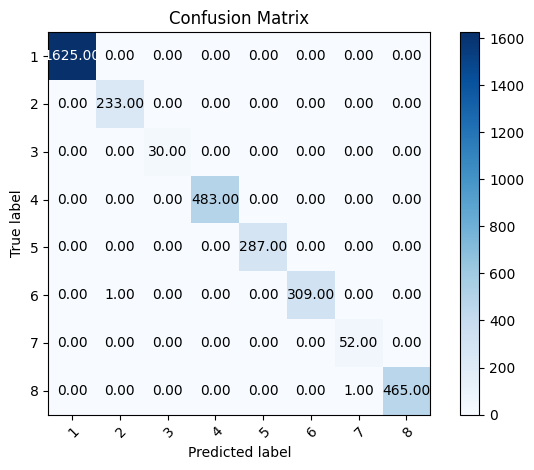


MLP Network A Accuracy: 0.9994262765347103
MLP Network A Precision: 0.9971073213997742
MLP Network A Recall: 0.9993285338502007
MLP Network A F1-Score: 0.9982056550139621
MLP Network A Matthew's Coefficient Correlation: [ 1.55669412 10.83354921 84.32093134  5.23732493  8.81403464  8.17328349
 48.18557468  5.43421998]


In [16]:
Y_eval_flattened = Y_eval.flatten().astype(np.int64)
mlp_a.load_weights(filename_network_weights)
Y_pred_network_a = mlp_a.forward(X_eval)
Y_pred_labels = probabilities_to_class_labels(Y_pred_network_a)

cm = confusion_matrix(Y_eval_flattened, Y_pred_labels)
accuracy, macro_precision, macro_recall, macro_f1_score, mcc = calculate_model_metrics(Y_eval_flattened, Y_pred_labels)

print(f"MLP Network A Confusion Matrix:")
plot_confusion_matrix(Y_eval_flattened, Y_pred_labels)
print(f"\nMLP Network A Accuracy: {accuracy}")
print(f"MLP Network A Precision: {macro_precision}")
print(f"MLP Network A Recall: {macro_recall}")
print(f"MLP Network A F1-Score: {macro_f1_score}")
print(f"MLP Network A Matthew's Coefficient Correlation: {mcc}")

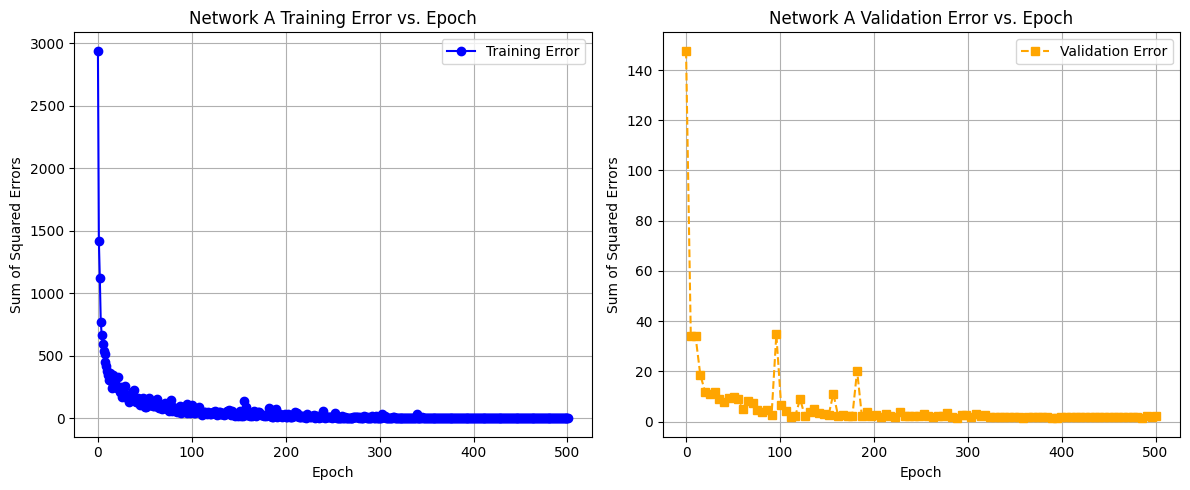

In [17]:
training_epochs = np.linspace(0, EPOCHS + 1, EPOCHS)
validation_epochs = np.linspace(0, EPOCHS + 1, EPOCHS//5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Training Error Plot
axes[0].plot(training_epochs, mlp_a.training_errors, label="Training Error", 
             marker="o", linestyle="-", color='blue')
axes[0].set_title("Network A Training Error vs. Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Sum of Squared Errors")
axes[0].grid(True)
axes[0].legend()

# Validation Error Plot
axes[1].plot(validation_epochs, mlp_a.validation_errors, label="Validation Error", 
             marker="s", linestyle='--', color='orange')
axes[1].set_title("Network A Validation Error vs. Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Sum of Squared Errors")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [18]:
# Generate predictions on the test set
Y_pred_network_a = mlp_a.forward(X_test)
print(Y_pred_network_a.shape) # Sanity check

# Save the predictions of Network A
write_csv(filename_network_a_pred, Y_pred_network_a)

(701, 8)


## Network B

Activation Functions
1. Leaky ReLU $\tanh$ (alpha = 0.01)
2. Leaky ReLU $\tanh$ (alpha = 0.01)
3. Logistic Function (a = 2)

In [19]:
# Define the grid of hyperparameters
param_grid = {
    "learning_rate": [0.001, 0.01, 0.1],
    "momentum": [0.9, 0.95, 0.99],
    "hidden_sizes": [[10, 10], [50, 50], [100, 100]] 
}

# Perform grid search to find the best set of hyperparameters
best_params = grid_search_for_mlp(X_train, Y_train, X_val, Y_val, 
                                  [LeakyReLU(), LeakyReLU(), LogisticFunction()], 
                                  param_grid, 
                                  epochs=EPOCHS, 
                                  batch_size=32)

print(f"best_params = {best_params}")

Hyperparameter Tuning:   0%|          | 0/27 [00:00<?, ?it/s]

Model training took 24.5492525100708 seconds
New best parameters found: {'learning_rate': 0.001, 'momentum': 0.9, 'hidden_sizes': [10, 10], 'validation_error': 3.675492147864202}
Model training took 40.17431139945984 seconds
New best parameters found: {'learning_rate': 0.001, 'momentum': 0.9, 'hidden_sizes': [50, 50], 'validation_error': 1.7122847951470268}
Model training took 77.18016457557678 seconds
New best parameters found: {'learning_rate': 0.001, 'momentum': 0.9, 'hidden_sizes': [100, 100], 'validation_error': 1.3016140002928844}
Model training took 24.597721338272095 seconds
Model training took 40.084240436553955 seconds
Model training took 76.72422957420349 seconds


C:\Users\lendl\AppData\Local\Temp\ipykernel_14968\2633481340.py:12: RuntimeWarning: overflow encountered in exp
  z = np.where(pos_mask, np.exp(-self.a * x), np.exp(self.a * x))


Model training took 24.833348274230957 seconds
Model training took 40.339492082595825 seconds
Model training took 77.08973407745361 seconds
Model training took 24.766584634780884 seconds
Model training took 40.229461669921875 seconds
Model training took 77.02769184112549 seconds


C:\Users\lendl\AppData\Local\Temp\ipykernel_14968\2155338681.py:84: RuntimeWarning: overflow encountered in matmul
  z = x @ self.weights[i]
C:\Users\lendl\AppData\Local\Temp\ipykernel_14968\2155338681.py:84: RuntimeWarning: invalid value encountered in matmul
  z = x @ self.weights[i]
C:\Users\lendl\AppData\Local\Temp\ipykernel_14968\2155338681.py:110: RuntimeWarning: invalid value encountered in matmul
  weight_gradient = self.layers[-2].T @ delta


Model training took 24.385215759277344 seconds
Model training took 40.321460008621216 seconds
Model training took 76.62429594993591 seconds
Model training took 23.875182628631592 seconds
Model training took 39.73373103141785 seconds
Model training took 76.16558599472046 seconds
Model training took 23.956799745559692 seconds
Model training took 39.52078199386597 seconds
Model training took 76.15614485740662 seconds
Model training took 24.069610595703125 seconds
Model training took 39.77388834953308 seconds
Model training took 75.96959018707275 seconds
Model training took 23.877297163009644 seconds
Model training took 39.712528228759766 seconds
Model training took 76.53651857376099 seconds
best_params = {'learning_rate': 0.001, 'momentum': 0.9, 'hidden_sizes': [100, 100], 'validation_error': 1.3016140002928844}


In [20]:
# Initialize the MLP with the Leaky ReLU as the squashing function
# for the hidden layers
input_size, output_size = X_train.shape[1], Y_train.shape[1]
# hidden_layer_sizes = [100, 100]
activation_functions = [LeakyReLU(), 
                        LeakyReLU(), 
                        LogisticFunction()
                        ]

# Train the MLP with the training and validation sets
mlp_b = MultiLayerPerceptron(input_size=input_size, 
                             hidden_sizes=best_params["hidden_sizes"], 
                             output_size=output_size, 
                             activation_functions=activation_functions,
                             learning_rate=best_params["learning_rate"],
                             momentum=best_params["momentum"])
mlp_b.train(X_train, Y_train, X_val, Y_val, EPOCHS)

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Validation Sum of Squared Errors: 146.02328500056348 | Misclassifications: 162
Epoch 5 | Validation Sum of Squared Errors: 37.106182155094274 | Misclassifications: 48
Epoch 10 | Validation Sum of Squared Errors: 16.613967663059043 | Misclassifications: 13
Epoch 15 | Validation Sum of Squared Errors: 25.35330059256404 | Misclassifications: 25
Epoch 20 | Validation Sum of Squared Errors: 16.058584441528378 | Misclassifications: 20
Epoch 25 | Validation Sum of Squared Errors: 8.292397455642895 | Misclassifications: 10
Epoch 30 | Validation Sum of Squared Errors: 5.91355337079159 | Misclassifications: 6
Epoch 35 | Validation Sum of Squared Errors: 7.293960154960157 | Misclassifications: 6
Epoch 40 | Validation Sum of Squared Errors: 8.950578723722057 | Misclassifications: 11
Epoch 45 | Validation Sum of Squared Errors: 4.085279852591269 | Misclassifications: 4
Epoch 50 | Validation Sum of Squared Errors: 4.241488690462419 | Misclassifications: 4
Epoch 55 | Validation Sum of Squar

In [21]:
# Save the trained weights of Network B for performance evaluation and inference on test data
mlp_b.save_best_weights(filename_network_weights)

MLP Network B Confusion Matrix:


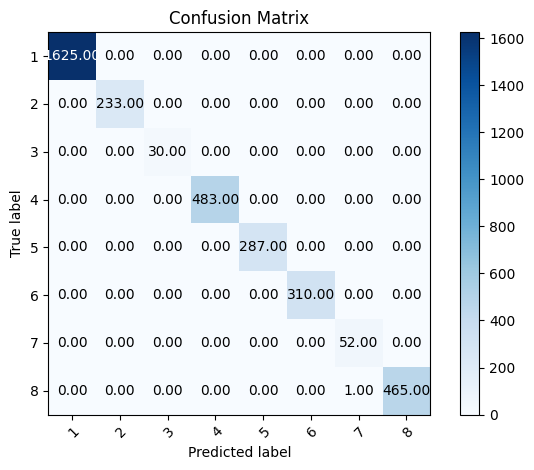


MLP Network B Accuracy: 0.9997131382673551
MLP Network B Accuracy: 0.9997131382673551
MLP Network B Precision: 0.9976415094339622
MLP Network B Recall: 0.9997317596566524
MLP Network B F1-Score: 0.9986752595775152
MLP Network B Matthew's Coefficient Correlation: [ 1.55729591 10.86096932 84.3535284   5.23934959  8.81744199  8.16324468
 48.20420241  5.43632076]


In [22]:
Y_eval_flattened = Y_eval.flatten().astype(np.int64)
mlp_b.load_weights(filename_network_weights)

Y_pred_network_b = mlp_b.forward(X_eval)
Y_pred_labels = probabilities_to_class_labels(Y_pred_network_b)

cm = confusion_matrix(Y_eval_flattened, Y_pred_labels)
accuracy, macro_precision, macro_recall, macro_f1_score, mcc = calculate_model_metrics(Y_eval_flattened, Y_pred_labels)

print(f"MLP Network B Confusion Matrix:")
plot_confusion_matrix(Y_eval_flattened, Y_pred_labels)
print(f"\nMLP Network B Accuracy: {accuracy}")
print(f"MLP Network B Accuracy: {accuracy}")
print(f"MLP Network B Precision: {macro_precision}")
print(f"MLP Network B Recall: {macro_recall}")
print(f"MLP Network B F1-Score: {macro_f1_score}")
print(f"MLP Network B Matthew's Coefficient Correlation: {mcc}")

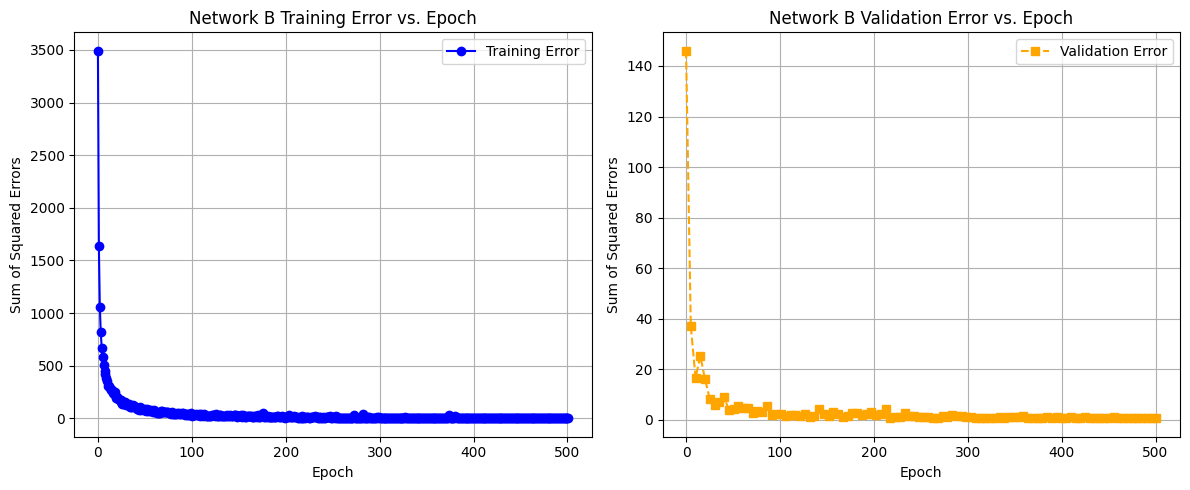

In [23]:
training_epochs = np.linspace(0, EPOCHS + 1, EPOCHS)
validation_epochs = np.linspace(0, EPOCHS + 1, EPOCHS//5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Training Error Plot
axes[0].plot(training_epochs, mlp_b.training_errors, label="Training Error", 
             marker="o", linestyle="-", color='blue')
axes[0].set_title("Network B Training Error vs. Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Sum of Squared Errors")
axes[0].grid(True)
axes[0].legend()

# Validation Error Plot
axes[1].plot(validation_epochs, mlp_b.validation_errors, label="Validation Error", 
             marker="s", linestyle='--', color='orange')
axes[1].set_title("Network B Validation Error vs. Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Sum of Squared Errors")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [24]:
# Generate predictions on the test set
Y_pred_network_b = mlp_b.forward(X_test)
print(Y_pred_network_b.shape) # Sanity check

# Save the predictions of Network B
write_csv(filename_network_b_pred, Y_pred_network_b)

(701, 8)
